# Exercise 5: PAC Learnable

In this assignment you will implement some aspect of the PAC Learnable framework

## Do not start the exercise until you fully understand the submission guidelines.

* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kindly reminder: the homework assignments contribute 50% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. Complete the required functions in in this notebook marke with TODO comment
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/), numpy and scipy only. **Do not import anything else.**
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains the this notebook as well as a file name `hw5.pdf` with the theoretical answers, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone.

In [25]:
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, bernoulli

In [26]:
# Configurable params
n_train_samples = 20  # m
n_test_samples = int(1e6)  # Will be used to estimate the entire infinite instance space
uni_lower_bound = -2
uni_upper_bound = 2
delta = 0.1  # How uncertain I am
true_error_prob = 0.02  # epsilon is the true error proabability
n_exp = 10_000  # Number of experiments we going to run to check our sample complexity bounds

# Visualize params
s = 0.9

In [27]:
# Utils
def draw_circle(radius: float,
                center_point: tuple = (0, 0),
                fill: bool = False,
                color: str = 'black') -> plt.Figure:
    fig, ax = plt.subplots()
    circle = plt.Circle(center_point, radius=radius, fill=fill, color=color)
    ax.add_patch(circle)
    eps = 0.3
    ax.set_ylim(uni_lower_bound - eps, uni_upper_bound + eps)
    ax.set_xlim(uni_lower_bound - eps, uni_upper_bound + eps)

    return fig

def draw_circles(radius: list, center_point: tuple = (0, 0), colormap='viridis') -> plt.Figure:
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap(colormap, len(radius))  # Get a colormap with enough colors
    eps = 0.3
    print(f"in draw_circles")
    for i, r in enumerate(radius):
        print(f"creating circle with radius: {r}")
        color = cmap(i)  # Get color from colormap
        circle = plt.Circle(center_point, radius=r, fill=False, color=color)
        ax.add_patch(circle)

    # Adjust the view limits
    max_radius = max(radius)
    ax.set_ylim(uni_lower_bound - eps, uni_upper_bound + eps)
    ax.set_xlim(uni_lower_bound - eps, uni_upper_bound + eps)

    return fig

# Instance space

In this exercise, our dataset consists of samples drawn from the distribution $\pi$. These samples belong to the subset $D \subseteq X$, where $X = \mathbb{R}^2$. The distribution $\pi$ follows a uniform distribution over the interval $[-2, 2]$.

In [28]:
def sample_uniform_instance_space(n_samples: int,
                                  uni_lower_bound: float,
                                  uni_upper_bound: float) -> np.ndarray:
    """
    Generate samples in R^2 from 2 independent uniform distribution with the same support.
    
    input:
    ------
    n_samples: int represents the number of isntances we want to generate
    uni_lower_bound: float the lower bound of the uniform distribution support
    uni_upper_bound: float the upper bound of the uniform distribution support
    
    return
    ------
    samples: 2d numpy array containing samples distributed according to 2 indepndent uniform distributions
    """
    x = np.random.uniform(uni_lower_bound, uni_upper_bound, n_samples)
    y = np.random.uniform(uni_lower_bound, uni_upper_bound, n_samples)

    # Stack arrays in sequence horizontally (column wise) to form a 2D array
    samples = np.column_stack((x, y))

    return samples

In [29]:
n_samples = 20
uni_lower_bound = -2
uni_upper_bound = 2
samples = sample_uniform_instance_space(n_samples=n_samples, uni_lower_bound=uni_lower_bound, uni_upper_bound=uni_upper_bound)

Text(0, 0.5, 'x2')

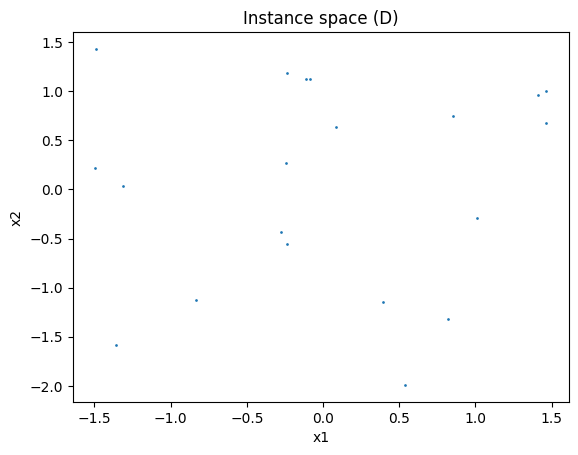

In [30]:
fig, ax = plt.subplots()

ax.scatter(samples[:, 0], samples[:, 1], s=s)
ax.set_title("Instance space (D)")
ax.set_xlabel("x1")
ax.set_ylabel("x2")

# Concept space

Our concept in this exercies will be the concentric circles  
$$c(r) = \{(x, y|x^2 +y^2 \leq r^2)\}$$

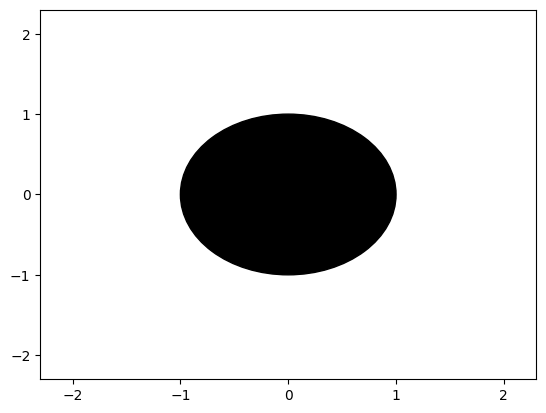

In [31]:
r_concept = 1. 
fig = draw_circle(radius=r_concept, fill=True)

# Hypothsis space

In this exercise, we will assume that our concept space and hypothesis space are the same, denoted by $H = C$. Therefore, our hypotheses will also take the form of concentric circles.

[-1.9        -1.47777778 -1.05555556 -0.63333333 -0.21111111  0.21111111
  0.63333333  1.05555556  1.47777778  1.9       ]
in draw_circles
creating circle with radius: -1.9
creating circle with radius: -1.4777777777777776
creating circle with radius: -1.0555555555555554
creating circle with radius: -0.6333333333333333
creating circle with radius: -0.21111111111111103
creating circle with radius: 0.21111111111111125
creating circle with radius: 0.6333333333333333
creating circle with radius: 1.0555555555555558
creating circle with radius: 1.4777777777777779
creating circle with radius: 1.9


/var/folders/94/42g1lqzd79s5924_nj36d7pm0000gn/T/ipykernel_54758/3447261336.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colormap, len(radius))  # Get a colormap with enough colors


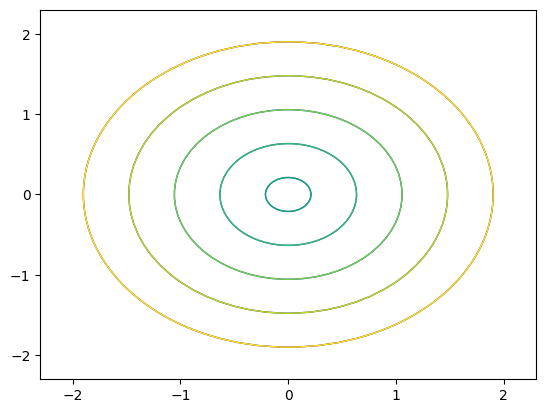

In [32]:
hypotesis_rs = np.linspace(-2 + 0.1, 2 - 0.1, 10) 
print(hypotesis_rs)
fig = draw_circles(radius=hypotesis_rs)

# Sample complexity

In class, we discussed the sample complexity bound for the case of concentric circles. Given $\varepsilon$, the desired maximal true error, and $1 - \delta$, the probability of achieving this error, the sample size $m(\varepsilon, \delta)\in O(f(\varepsilon), g(\delta))$. Use this bound to determine the minimum number of samples required to achieve these guarantees.

In [33]:
def sample_bound(true_error: float, uncertentity: float) -> int:
    """
    Return the sample complexity of cocentric circle in R^2 problem
    
    input:
    ------
    true_error: float desired upper bound on our true error
    uncertentity: float 1 - probability to get this error for a random dataset
    
    return:
    -------
    m: int the number of minimal samples
    """
    m =  np.log(1/uncertentity)/true_error
    return int(np.ceil(m))



In [34]:
eps = 0.02
delta = 0.05

n_train_samples = sample_bound(true_error=eps, uncertentity=delta)
f"we will need at least m={n_train_samples} samples in order to get true error of at most {eps} with probability of {1-delta}"

'we will need at least m=150 samples in order to get true error of at most 0.02 with probability of 0.95'

# Bulding our training set

In [35]:
concept_r = 1.

samples = sample_uniform_instance_space(n_train_samples,-2,2)
# A callable that gets as input a samples and return an indicator if they belong to the concept or not
concept_func = lambda x, y: np.sqrt(x**2 + y**2) <= concept_r


x1 = samples[:, 0]
x2 = samples[:, 1]
# The concept (label) of your training data
c_train = concept_func(x1, x2)
# This is the actual expreiment data set (D)
train_data = np.vstack([x1, x2, c_train]).T

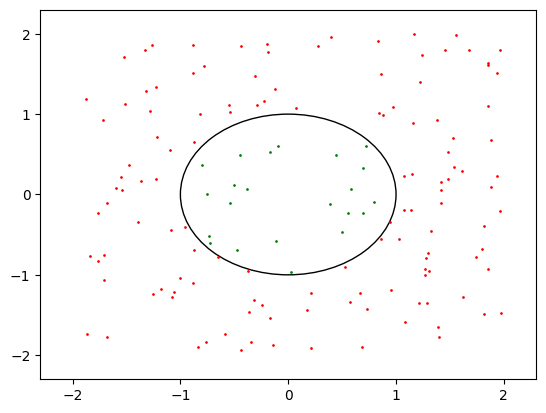

In [36]:
# Visualizing all toghther
fig = draw_circle(radius=concept_r)
plt.scatter(train_data[c_train.astype('bool'), 0], train_data[c_train.astype('bool'), 1], s=s, c='g')
plt.scatter(train_data[~c_train.astype('bool'), 0], train_data[~c_train.astype('bool'), 1], s=s, c='r')

# Consistent learner

In [37]:
def learning_algorithm(D: np.ndarray, c: np.ndarray) -> float:
    """
    The concetric circles consistent learning algorithm
    
    input:
    ------
    D: a 2d numpy array consist of the training instances
    c: a 1d numpy array consist of the concept values (label) 
    
    return:
    -------
    hypothesis_r: float the radius of our learned hypothesis
    """
    hypothesis_r = 1e-6
    is_instance_belongs_to_concept = c == 1

    # Handle the case: in our dataset all the labels are the same
    if is_instance_belongs_to_concept.sum() == 0:
        return hypothesis_r
    
    i =0
    points_true = 0
    for point in D:
        if c[i] == True:
            points_true +=1
            point_d = np.sqrt(point[0]**2 + point[1]**2)
            if(point_d > hypothesis_r):
                hypothesis_r = point_d
        i+=1
    return hypothesis_r

In [38]:
# L(D)
hypothesis_r = learning_algorithm(D=train_data[:, :-1], c=train_data[:, -1])
hypothesis_r

0.9649647742440713

In [39]:
###########################################################################
# TODO: Implement this cell.                                              #
###########################################################################
# A callable that gets as input a samples and return an indicator if they belong to the hypotesis or not
hypotesis_func = lambda x, y: np.sqrt(x**2 + y**2) <= hypothesis_r
# The predictions according to the hypotesis

x1 = samples[:, 0]
x2 = samples[:, 1]
c_pred = hypotesis_func(x1, x2)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

# Check consistency (make sure you are not failing here due to numerical stability issues)
assert (c_pred == c_train).all(), "your learner is not consistent!"

in draw_circles
creating circle with radius: 1.0
creating circle with radius: 0.9649647742440713


/var/folders/94/42g1lqzd79s5924_nj36d7pm0000gn/T/ipykernel_54758/3447261336.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colormap, len(radius))  # Get a colormap with enough colors


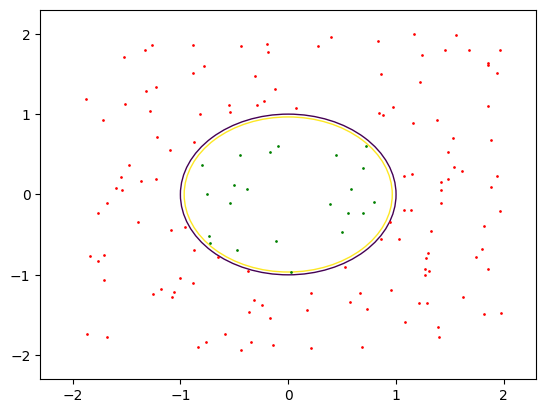

In [40]:
# Visualizing the training data set
fig = draw_circles(radius=[concept_r, hypothesis_r])
plt.scatter(train_data[c_train.astype('bool'), 0], train_data[c_train.astype('bool'), 1], s=s, c='g')
plt.scatter(train_data[~c_train.astype('bool'), 0], train_data[~c_train.astype('bool'), 1], s=s, c='r')

In [41]:
# Let's sample more instances from our distribution over X
test_samples = sample_uniform_instance_space(n_samples=n_test_samples, uni_lower_bound=uni_lower_bound, uni_upper_bound=uni_upper_bound)

# Does the instance belong to the concept
x1 = test_samples[:, 0]
x2 = test_samples[:, 1]
c_test = concept_func(x1, x2)
test_data = np.vstack([x1, x2, c_test]).T

# Does the instance belong to the hypothesis
c_pred = hypotesis_func(test_data[:, 0], test_data[:, 1])

# True Error Calculations
The plot below illustrates the following:

Instances in red represent points from $\Omega=(X, \pi)$ that neither belong to the concept nor the hypothesis.  
Instances in green are points from $\Omega=(X, \pi)$ that belong to both the concept and the hypothesis.  
Instances in blue show points from $\Omega=(X, \pi)$ that belong to the concept but not to the hypothesis.

This means that the blue instances represent the true error.

/var/folders/94/42g1lqzd79s5924_nj36d7pm0000gn/T/ipykernel_54758/3447261336.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(colormap, len(radius))  # Get a colormap with enough colors


in draw_circles
creating circle with radius: 1.0
creating circle with radius: 0.9649647742440713


Text(0, 0.5, 'x2')

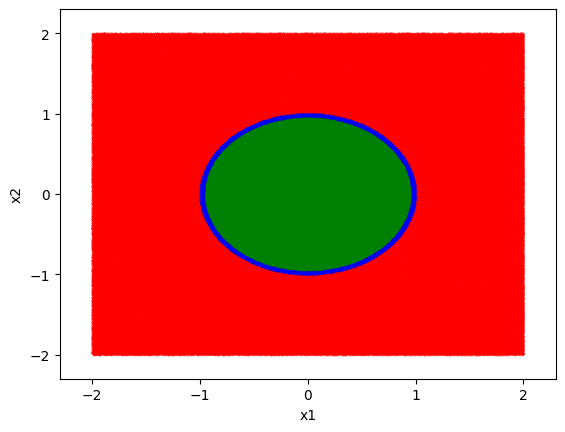

In [42]:
# True error empirical estimation
is_error = c_pred != c_test

# In the blue this is the wrongly classified instances (True error)
_ = draw_circles(radius=[concept_r, hypothesis_r])
plt.scatter(test_data[c_test.astype('bool'), 0], test_data[c_test.astype('bool'), 1], s=0.01, c='g')
plt.scatter(test_data[~c_test.astype('bool'), 0], test_data[~c_test.astype('bool'), 1], s=0.01, c='r')
plt.scatter(test_data[is_error, 0], test_data[is_error, 1], s=0.01, c='b')

plt.gca().set_xlabel("x1")
plt.gca().set_ylabel("x2")

Implement a function that calculting the true error $\pi(c(x)\neq h(x)$ HINT: the square total area is 16, what does it mean in probability tems?

In [43]:
def calculte_true_error(concept_r: float, hypothesis_r: float) -> float:
    """
    Calculting the true error of cocentric circle under the uniform distribution over [-2, 2]
    
    input:
    ------
    concept_r: float the radius of the concept 
    hypothesis_r: float the radius of the learnt hypothesis
    
    return:
    error_rate: float the true error
    """
    error_rate = 0.
    concept_area = np.pi * concept_r**2
    hypothesis_area = np.pi * hypothesis_r**2

    concept_prob = concept_area/16
    hypothesis_prob = hypothesis_area/16

    return abs(concept_prob - hypothesis_prob)

In [44]:
true_error = calculte_true_error(
    concept_r=concept_r,
    hypothesis_r=hypothesis_r
)

print(f"True error rate is: {true_error:.3f}")

True error rate is: 0.014


# Sufficent VS Insufficient sampling

Given the following scenario:
$\pi$ is the same as above  
$c(r = 1)$  
$\varepsilon = 0.02$  
$\delta = 0.05$  
Create the following graph using the below methods twice:
1. With sufficent number of samples
2. With insufficent number of samples

NOTE: in praticular you need to caclulte the emeprical $\delta$ for each one of the above scenarios

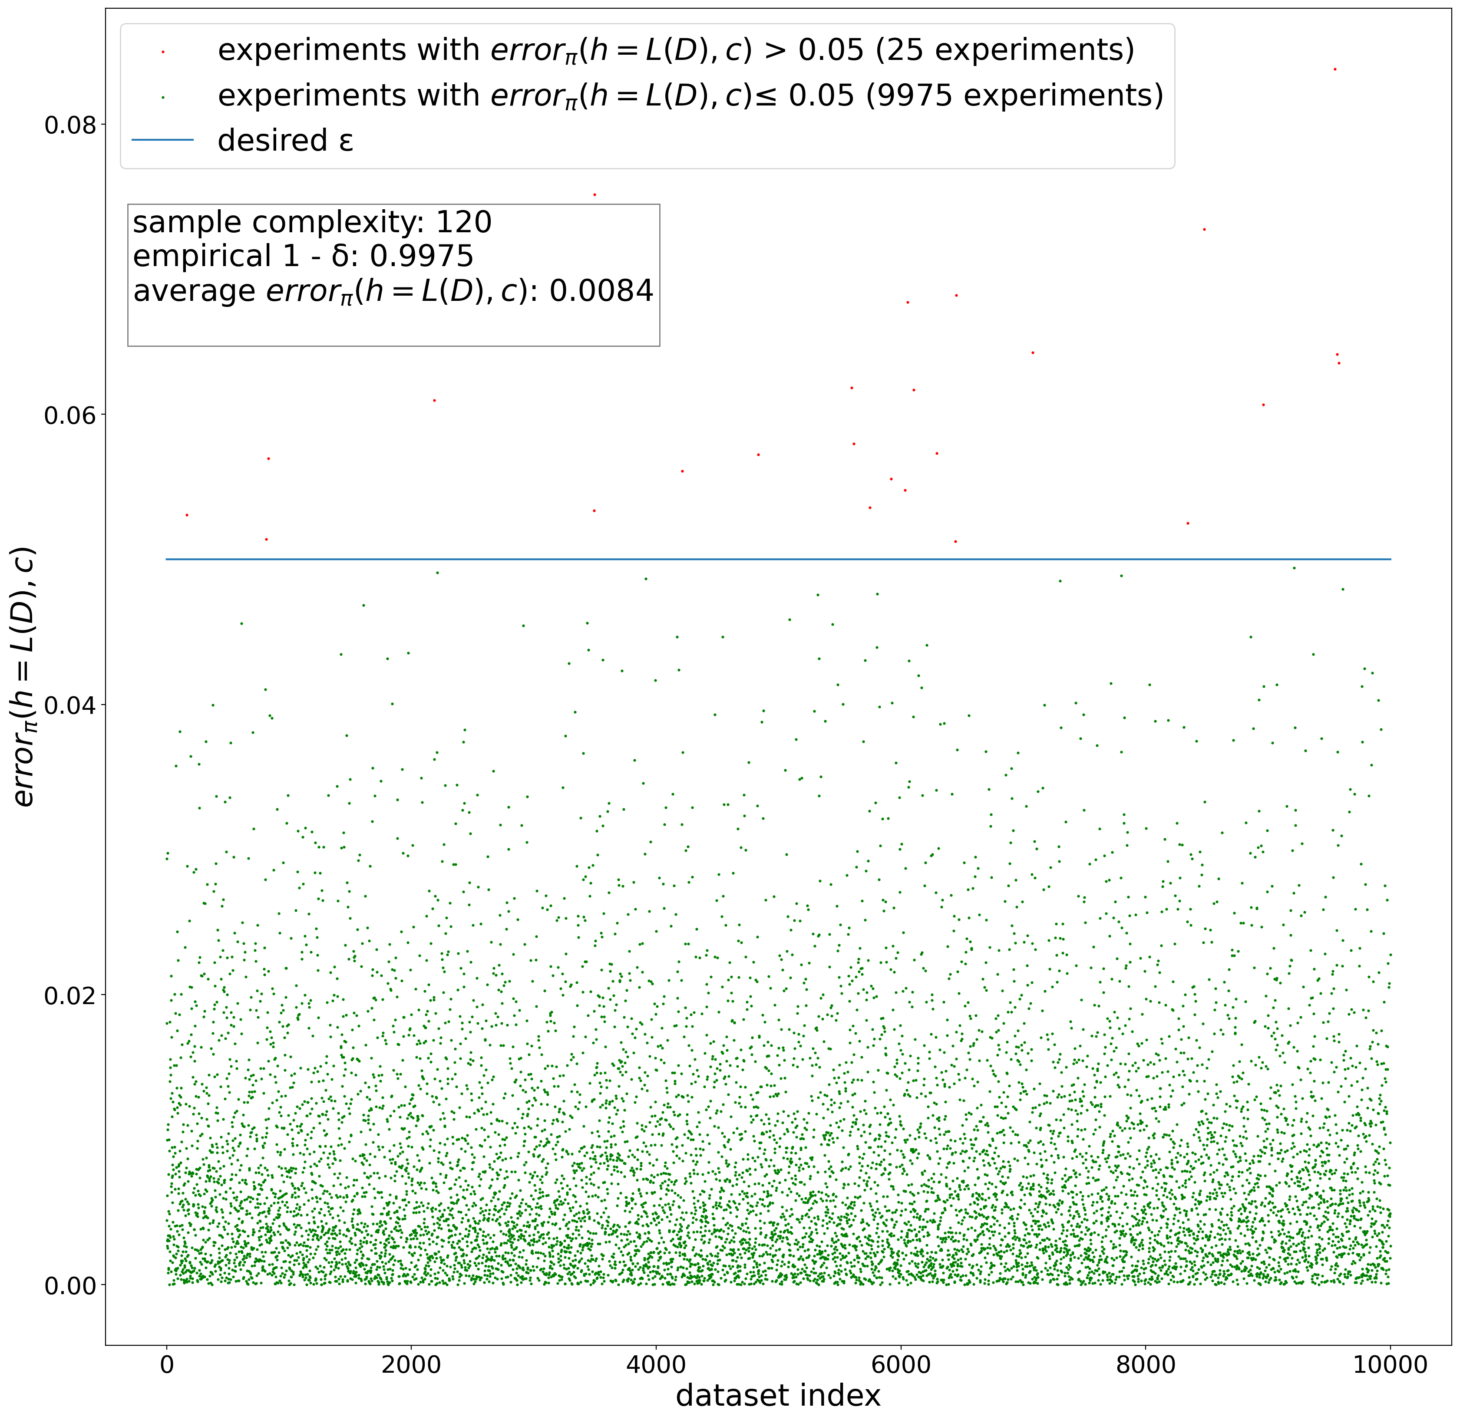

In [45]:
def run_single_expriment(n_samples: int, concept_r: float, epsilon: float, delta: float):
    if n_samples is None:
        raise ValueError(f"n_samples must be a valid integer not None")
        
    # Sample the training dataset
    samples = sample_uniform_instance_space(n_samples=n_samples, uni_lower_bound=uni_lower_bound, uni_upper_bound=uni_upper_bound)
    x1 = samples[:, 0]
    x2 = samples[:, 1]
    c_train = concept_func(x1, x2)
    # This is the actual expreiment data set (D)
    train_data = np.vstack([x1, x2, c_train]).T
    hypothesis_r = learning_algorithm(D=train_data[:, :-1], c=train_data[:, -1])
    error_rate = calculte_true_error(concept_r=concept_r, hypothesis_r=hypothesis_r)
    
    return error_rate

def plot_many_experiemnts(n_samples: int, n_exp: int, concept_r: float, epsilon: float, delta: float):
    error_rates = []
    experiment_indices = []
    for exp_num in range(n_exp):
        error = run_single_expriment(n_samples=n_samples, concept_r=concept_r, epsilon=epsilon, delta=delta)
        error_rates.append(error)
        experiment_indices.append(exp_num)

    error_rates = np.array(error_rates)
    # Convert error rates to a NumPy array for easier manipulation
    errors_above_epsilon = np.where(error_rates > epsilon)[0]
    errors_below_epsilon = np.where(error_rates <= epsilon)[0]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(np.array(experiment_indices)[errors_below_epsilon], error_rates[errors_below_epsilon], color='green', s=5, label=f'experiments with error ≤ {epsilon} ({len(errors_below_epsilon)} experiments)')
    ax.scatter(np.array(experiment_indices)[errors_above_epsilon], error_rates[errors_above_epsilon], color='red', s=5, label=f'experiments with error > {epsilon} ({len(errors_above_epsilon)} experiments)')
    ax.axhline(y=epsilon, color='blue', linestyle='--', label='desired ε')

    # Annotations
    empirical_delta = 1 - len(errors_above_epsilon) / n_exp
    average_error = np.mean(error_rates)
    annotation_text = f"sample complexity: {n_samples}\nempirical 1 - δ: {empirical_delta:.4f}\naverage error: {average_error:.4f}"
    ax.annotate(annotation_text, xy=(0.5, 0.5), xycoords='axes fraction', fontsize=12,
                bbox=dict(boxstyle="round", fc="w"))

    # Final touches
    ax.set_xlabel("Dataset Index")
    ax.set_ylabel("Error")
    ax.set_title("Error Distribution Across Datasets")
    ax.legend()
    plt.show()
    
    

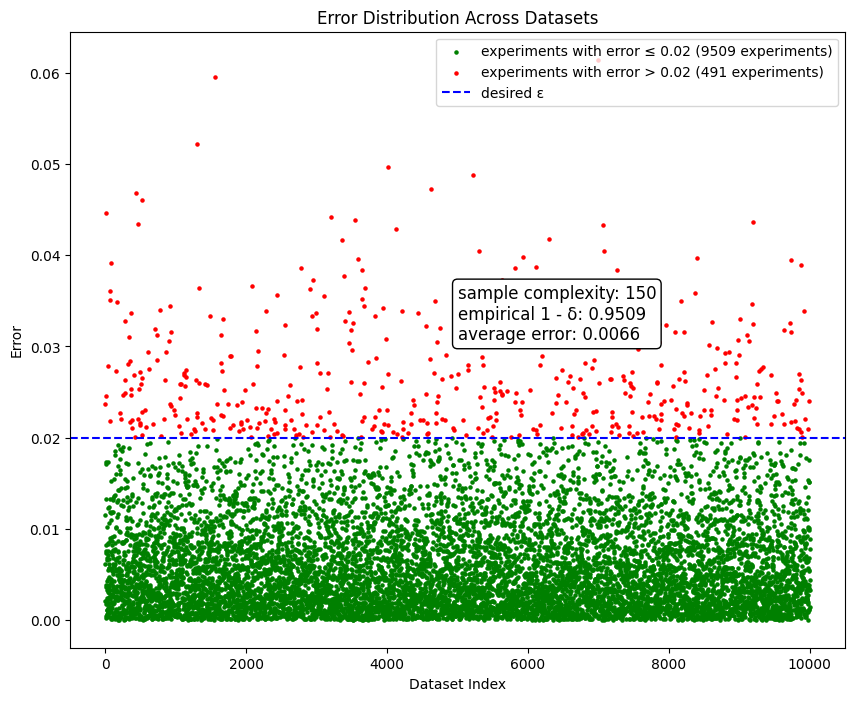

In [46]:

concept_r = 1.
epsilon = 0.02
delta = 0.05
n_samples = sample_bound(true_error=epsilon, uncertentity=delta)

plot_many_experiemnts(n_samples=n_samples, n_exp=n_exp, concept_r=concept_r, epsilon=epsilon, delta=delta)

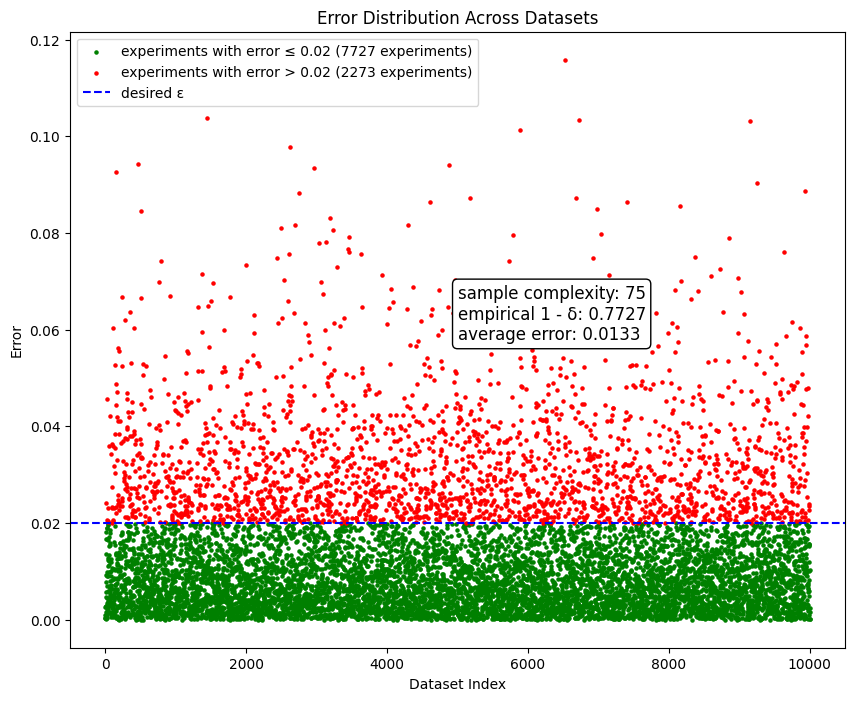

In [47]:

plot_many_experiemnts(n_samples=n_samples//2, n_exp=n_exp, concept_r=concept_r, epsilon=epsilon, delta=delta)

Given the same values for $\varepsilon$ and $𝑚$, if we change $c$ so that $𝑟=0.6$  
how would you expect the plot to change?
Additionally, how do you expect the empirical $delta$ to change? Please explain in a new text cell.

**Your explentation here**

Decreasing the radius of the circle from its original size to r=0.6 directly affects the area within which data points are considered to be part of the concept.
The area of a circle with radius  r=0.6 is approximately 1.13 down from 3.14 for a unit circle.
This reduction from about 3.14/16 to 1.13/16 means a smaller proportion of the total space is within the desired concept.
As a result, the likelihood of randomly sampled points falling within the concept's boundaries decreases significantly.
This change means fewer points will be correctly identified as within the concept, which could potentially degrade the performance of our learning algorithm due to 
having fewer relevant data points to learn from.

Expected Changes in the Plot:
The plot is likely to display a significantly higher number of red dots (representing experiments where the error exceeds error = 0.02
This is because the learning algorithm, which now has less accurate or representative training data, will likely result in a hypothesis that poorly approximates the actual concept.

Expected changes in Empirical delta:
With an increased number of experiments resulting in errors greater than epsilon the empirical delta (the proportion of experiments where the true error exceeds epsilon)will increase.
This implies a decrease in 1-delta, indicating that our confidence in the algorithm's performance has diminished due to the smaller concept area relative to the total space.

In summary, reducing the concept's radius makes it statistically less probable for points to fall within the concept,
potentially raising both the average empirical error and the empirical delta.
These effects result in a less effective learning process as the algorithm has fewer correct instances to learn from, leading to a general decrease in performance reliability.